In [1]:
import numpy as np

In [2]:
def remove_bad_chs(channel_groups, bad_ch_list):
    for k, v in channel_groups.items():
        for ch in v['channels']:
            if ch in bad_ch_list:
                idx = v['channels'].index(ch)
                v['channels'].pop(idx)
                v['geometry'].pop(ch)
    return channel_groups

def convert_sites_to_channels(site_groups, acq_channels_numbers, acq_site_mapping):
    """
    This maps sites to channels for geometries and the site lists. Also checks for integrity of site lists.
    
    site_groups is a dictionary with sites and geometries keys.
    acq_channel_numbers is a list of channels in order from the acquistion system (ie a range from 0-63).
    acq_site_mapping is a list of site numbers corresponding to the acquisition channel numbers specified above.
    
    
    So this will map:
        site_groups {
            0: {
            'sites': [46,45,44]
            }
        }
        acq_channel_numbers = [1,2,3]
        acq_site_mapping = [45, 46, 46]
        
        to:
        site_groups {
            0: {
            'sites': [3, 2, 1]
            }
        }
    """
    all_ch = []
    for k, v in site_groups.items():
        all_ch.extend(v['sites'])
    print ("{0} sites found on all groups.".format(len(all_ch)))
    bad = False
    for i in all_ch:
        nmatches = 0
        for ii in all_ch:
            if ii == i:
                nmatches += 1
        if nmatches >= 2:
            print ("ERROR: duplicate site of number {0} found.".format(i))
            bad = True
    if bad:
        return None
    else:
        print ("No duplicate channels.")
        
    for k, v in site_groups.items():
        site_list = v['sites']
        geo = v['geometry'].keys()
        
        assert len(site_list) == len(geo)
        
        for s in site_list:
            if s not in geo:
                raise ValueError('Site {0} specified in "sites" but not in "geometry" for shank {1}'.format(s, k))
        for s in geo:
            if s not in site_list:
                raise ValueError('Site {0} specified in "geometry" but not "sites" for shank {1}'.format(s, k))        
    print('Site and geometry lists are congruent.')
    
    channel_groups = {}
    for g, v in site_groups.items():
        channel_group = {}
        channels = []
        geometry = {}
        for s in v['sites']:
            site_idx = acq_site_mapping.index(s)
            ch = acq_channels_numbers[site_idx]
            channels.append(ch)
        channel_group['channels'] = channels
        
        for s, v in v['geometry'].items():
            site_idx = acq_site_mapping.index(s)
            ch = acq_channels_numbers[site_idx]
            geometry[ch] = v
        channel_group['geometry'] = geometry
        
        channel_groups[g] = channel_group
    return channel_groups

def linear_shank_graph(channel_list):
    """
    makes a graph to connect sites on a linear probe (ie Buszaki 64)
    """
    graph = []
    for i in range(len(channel_list)):
        a1 = channel_list[i]
        for ii in range(1, 3):
            try:
                a2 = channel_list[i+ii]
                graph.append((a1, a2))
            except:
                pass
    return graph

def make_graphs(channel_groups):
    for k in  channel_groups.keys():
        group = channel_groups[k]
        channels = group['channels']
        group['graph'] = linear_shank_graph(channels)
    return channel_groups

In [19]:
tt = np.loadtxt('/home/cdw291/remotes/rinberglabspace/Experiments/2016_Piriform_LR+CW/preprocessed_data/LRP1/probe/whisper_to_NeuroNexus.csv',
                delimiter=",", dtype=int, skiprows=1)



In [20]:
tt[:,1]

array([48, 46, 45, 43, 42, 40, 39, 37, 36, 38, 35, 41, 34, 44, 33, 47, 18,
       32, 21, 31, 24, 30, 27, 29, 28, 26, 25, 23, 22, 20, 19, 17, 16, 14,
       12, 10,  8,  6,  4,  2,  1,  3,  5,  7,  9, 11, 13, 15, 50, 52, 54,
       56, 58, 60, 62, 64, 63, 61, 59, 57, 55, 53, 51, 49])

[42, 46, 48, 45, 43, 34, 36, 40, 39, 38, 37, 41, 35, 47, 33, 44, 19,
       26, 24, 28, 18, 30, 29, 32, 31, 27, 25, 20, 22, 23, 21, 17, 10, 14,
       15, 11,  2,  6,  7,  3,  1,  5,  8,  4,  9, 13, 16, 12, 51, 55, 54,
       50, 59, 63, 62, 58, 60, 64, 61, 57, 52, 56, 53, 49]

In [21]:
len(tt)

64

In [31]:
SGL_64 = {
    'raw_channels': range(64),
    'NN_H64LP': list(tt[:,1]),
    'NanoZ': [
    ],
}

In [32]:
geometries = ((0, 0), (-8, 20), (8, 40), (-12, 60), (12, 80), (-16, 100), (16, 120), (-20, 140), )

site_groups = {
    0: {
        'sites': [5,4,6,3,7,2,8,1]
    },
    1: {
        'sites': [13,12,14,11,15,10,16,9]
    },
    2: {
        'sites': [21,20,22,19,23,18,24,17]
    },
    3: {
        'sites': [29,28,30,27,31,26,32,25]
    },
    4: {
        'sites': [37,36,38,35,39,34,40,33]
    },
    5: {
        'sites': [45,44,46,43,47,42,48,41]
    },
    6: {
        'sites': [53,52,54,51,55,50,56,49]
    },
    7: {
        'sites': [61,60,62,59,63,58,64,57]
    }
}

In [33]:
for gnum, group in site_groups.items():
    group['geometry'] = {}
    sites = group['sites']
    assert len(group['sites']) == len(geometries)
    for i in range(len(sites)):
        sitenum = sites[i]
        pos = geometries[i]
        group['geometry'][sitenum] = (pos[0] + 200*gnum, pos[1])

In [34]:
site_groups

{0: {'geometry': {1: (-20, 140),
   2: (-16, 100),
   3: (-12, 60),
   4: (-8, 20),
   5: (0, 0),
   6: (8, 40),
   7: (12, 80),
   8: (16, 120)},
  'sites': [5, 4, 6, 3, 7, 2, 8, 1]},
 1: {'geometry': {9: (180, 140),
   10: (184, 100),
   11: (188, 60),
   12: (192, 20),
   13: (200, 0),
   14: (208, 40),
   15: (212, 80),
   16: (216, 120)},
  'sites': [13, 12, 14, 11, 15, 10, 16, 9]},
 2: {'geometry': {17: (380, 140),
   18: (384, 100),
   19: (388, 60),
   20: (392, 20),
   21: (400, 0),
   22: (408, 40),
   23: (412, 80),
   24: (416, 120)},
  'sites': [21, 20, 22, 19, 23, 18, 24, 17]},
 3: {'geometry': {25: (580, 140),
   26: (584, 100),
   27: (588, 60),
   28: (592, 20),
   29: (600, 0),
   30: (608, 40),
   31: (612, 80),
   32: (616, 120)},
  'sites': [29, 28, 30, 27, 31, 26, 32, 25]},
 4: {'geometry': {33: (780, 140),
   34: (784, 100),
   35: (788, 60),
   36: (792, 20),
   37: (800, 0),
   38: (808, 40),
   39: (812, 80),
   40: (816, 120)},
  'sites': [37, 36, 38, 35, 39,

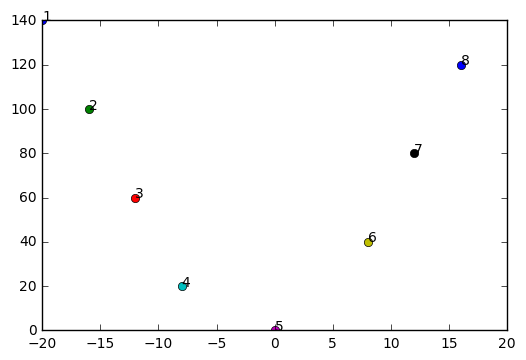

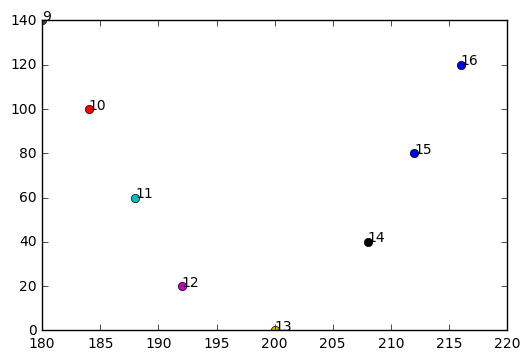

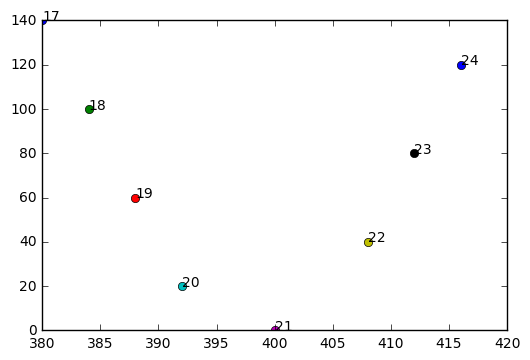

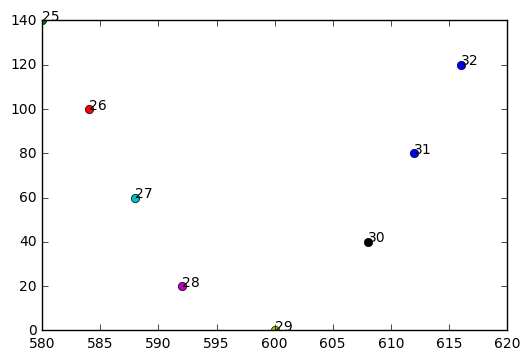

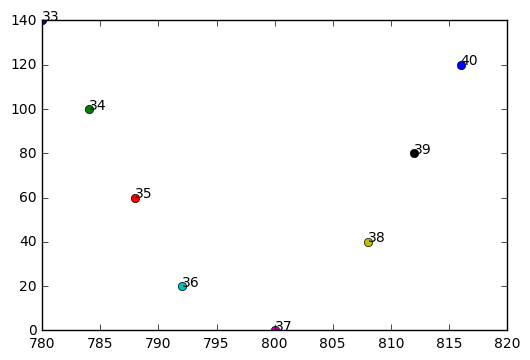

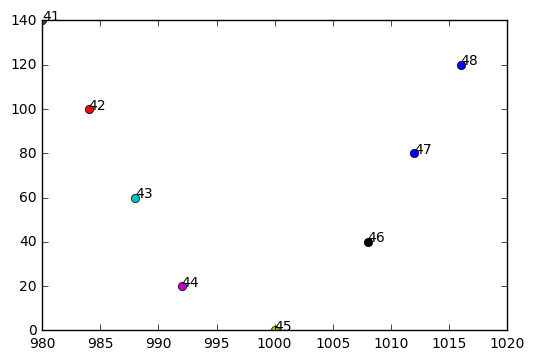

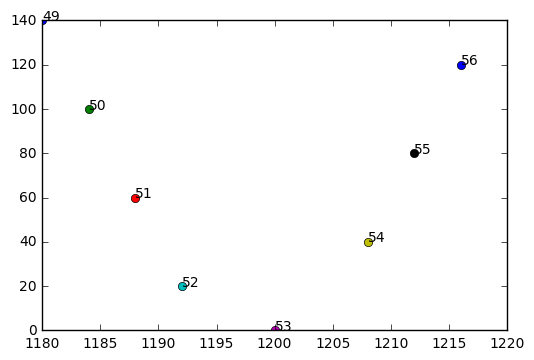

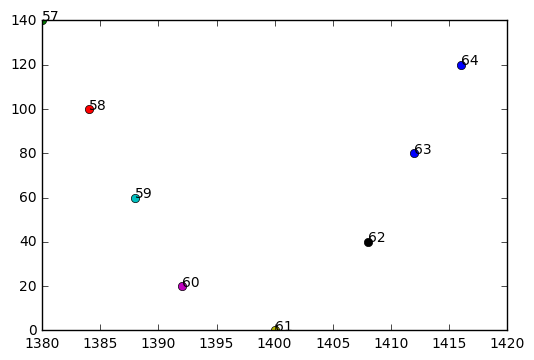

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
for g in site_groups.values():
    for num, pos in g['geometry'].items():
        plt.plot(pos[0], pos[1], 'o')
        plt.text(pos[0], pos[1], num)
    plt.show()

In [36]:
channel_groups = convert_sites_to_channels(site_groups, SGL_64['raw_channels'], SGL_64['NN_H64LP'])

64 sites found on all groups.
No duplicate channels.
Site and geometry lists are congruent.


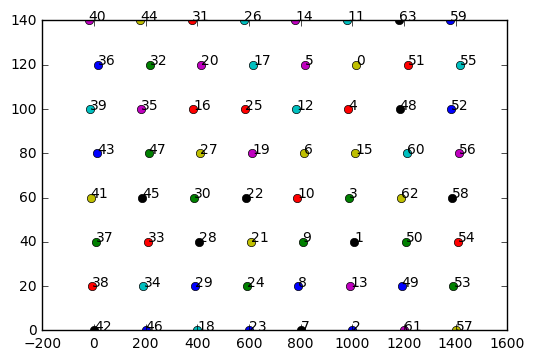

In [37]:
for g in channel_groups.values():
    for num, pos in g['geometry'].items():
        plt.plot(pos[0], pos[1], 'o')
        plt.text(pos[0], pos[1], num)

In [38]:
NZ_bad = []
def nz_to_sgl(nz_chs, acq_ch_map, nz_ch_map):
    ac_chs = []
    for ch in nz_chs:
        idx = nz_ch_map.index(ch)
        ac_chs.append(acq_ch_map[idx])
        ac_chs.sort()
    return ac_chs

a= nz_to_sgl(NZ_bad, SGL_64['raw_channels'], SGL_64['NanoZ'])
print (a)
print ([x+64 for x in a])

[]
[]


In [39]:
channel_groups = remove_bad_chs(channel_groups, [])

In [40]:
channel_groups = make_graphs(channel_groups)

In [41]:
channel_groups

{0: {'channels': [42, 38, 37, 41, 43, 39, 36, 40],
  'geometry': {36: (16, 120),
   37: (8, 40),
   38: (-8, 20),
   39: (-16, 100),
   40: (-20, 140),
   41: (-12, 60),
   42: (0, 0),
   43: (12, 80)},
  'graph': [(42, 38),
   (42, 37),
   (38, 37),
   (38, 41),
   (37, 41),
   (37, 43),
   (41, 43),
   (41, 39),
   (43, 39),
   (43, 36),
   (39, 36),
   (39, 40),
   (36, 40)]},
 1: {'channels': [46, 34, 33, 45, 47, 35, 32, 44],
  'geometry': {32: (216, 120),
   33: (208, 40),
   34: (192, 20),
   35: (184, 100),
   44: (180, 140),
   45: (188, 60),
   46: (200, 0),
   47: (212, 80)},
  'graph': [(46, 34),
   (46, 33),
   (34, 33),
   (34, 45),
   (33, 45),
   (33, 47),
   (45, 47),
   (45, 35),
   (47, 35),
   (47, 32),
   (35, 32),
   (35, 44),
   (32, 44)]},
 2: {'channels': [18, 29, 28, 30, 27, 16, 20, 31],
  'geometry': {16: (384, 100),
   18: (400, 0),
   20: (416, 120),
   27: (412, 80),
   28: (408, 40),
   29: (392, 20),
   30: (388, 60),
   31: (380, 140)},
  'graph': [(18, 

In [42]:
try:
    from pprint import pformat
except ImportError:
    pformat = print
f = open('/home/cdw291/probes/Buzsaki64H64LP-whisper.prb', 'w')
f.write("channel_groups = {0}\n".format(pformat(channel_groups)))
f.close()

DOUBLE DOWN
---
Make a probe file for double 64 ch probes

In [13]:
# dual_ch_groups = {}
# group_shifts = (0,4)
# ch_shifts = (0, 64)

# for gshift, cshift in zip(group_shifts, ch_shifts):
#     for k, v in channel_groups.items():
#         channels = [x + cshift for x in v['channels']]
#         geometry = {}
#         for kk, vv in v['geometry'].items():
#             geometry[kk + cshift] = vv
#         graph = []
#         for i in v['graph']:
#             graph.append([x+cshift for x in i])
#         dual_ch_groups[k+gshift] = {
#             'channels': channels,
#             'geometry': geometry,
#             'graph': graph
#         }


In [15]:
cgroupsdual = {}
for k, v in channel_groups.items():
    cgroupsdual[k] = v
    gnum = k+4
    cgroupsdual[gnum] = {'geometry': {}}
    
    cgroupsdual[gnum]['channels'] = [x+64 for x in v['channels']]
    for s, g in v['geometry'].items():
        cgroupsdual[gnum]['geometry'][s+64] = (g[0]+ 800, g[1])
    cgroupsdual[gnum]['graph'] = []

In [16]:
f = open('/home/cdw291/probes/whisper/HIRES_dual_spyking.prb', 'w')
# pickle.dump(channel_groups, f, 0)
f.write("channel_groups = {0}\n".format(pformat(cgroupsdual)))
f.close()

In [ ]:
from pprint import pprint

In [ ]:
pprint (cgroupsdual)

In [ ]:
a = {'a' : {'b': 84}}

In [ ]:
b = {}
b['a'] = a['a']

In [ ]:
b['a']['b'] += 1

In [ ]:
a